In [1]:
# Imports.
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

tfd = tf.contrib.distributions


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
# Model & Plotting.

# Encoder.
def make_encoder(data, code_size):
    x = tf.layers.flatten(data)
    h1 = tf.layers.dense(x, 256, tf.nn.relu)
    h2 = tf.layers.dense(h1, 256, tf.nn.relu)
    loc = tf.layers.dense(h2, code_size)
    scl = tf.layers.dense(h2, code_size, tf.nn.softplus)
    return tfd.MultivariateNormalDiag(loc, scl)

# Prior.
def make_prior(code_size):
    loc = tf.zeros(code_size)
    scl = tf.ones(code_size)
    return tfd.MultivariateNormalDiag(loc, scl)

# Decoder
def make_decoder(code, data_shape):
    x = code
    h1 = tf.layers.dense(x, 256, tf.nn.relu)
    h2 = tf.layers.dense(h1, 256, tf.nn.relu)
    loc = tf.layers.dense(h2, np.prod(data_shape), tf.nn.tanh)
    scl = tf.layers.dense(h2, np.prod(data_shape), tf.nn.softmax)    
    return loc, scl

# Plotting.
def plot(epoch, codes, labels, samples, size=1):
    ig, ax = plt.subplots(ncols=1 + len(samples), figsize=((1 + len(samples)) * size, size))
    no_ticks = dict(left='off', bottom='off', labelleft='off', labelbottom='off')
    ax[0].set_ylabel('Epoch {}'.format(epoch))
    ax[0].scatter(codes[:, 0], codes[:, 1], s=2, c=labels, alpha=0.1)
    ax[0].set_aspect('equal')
    ax[0].set_xlim(codes.min() - .1, codes.max() + .1)
    ax[0].set_ylim(codes.min() - .1, codes.max() + .1)
    ax[0].tick_params(axis='both', which='both', **no_ticks)
    for index, sample in enumerate(samples):
        ax[1 + index].imshow(sample, cmap='gray')
        ax[1 + index].tick_params(axis='both', which='both', **no_ticks)
    plt.show()

# Optimisation
make_encoder = tf.make_template('encoder', make_encoder)
make_decoder = tf.make_template('decoder', make_decoder)

In [3]:
# Dataset retrieval.
mnist = tf.keras.datasets.mnist.load_data()
train = mnist[0]
test = mnist[1]

# Training set (normalized)
X_train = train[0]/255
y_train = train[1]

# Test set (normalized)
X_test = test[0]/255
y_test = test[1]

In [4]:
# 32-dimensional latent  space
data = tf.placeholder(tf.float32, [None, 28, 28])

# Define the model.
prior = make_prior(code_size=32)
posterior = make_encoder(data, code_size=32)
code = posterior.sample()

# Define the loss.
loc, scl = make_decoder(code, [28, 28])

mvn = tfd.MultivariateNormalDiag(loc, scl)
likelihood = mvn.log_prob(tf.reshape(data, [-1, 784]))

divergence = tfd.kl_divergence(posterior, prior)
elbo = tf.reduce_mean(likelihood - divergence)
optimize = tf.train.AdamOptimizer(0.001).minimize(-elbo)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlo

In [5]:
samples, _ = make_decoder(prior.sample(10), [28, 28])

elbos = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(1000):
        test_elbo, test_codes, test_samples, test_loc = sess.run([elbo, code, samples, loc], {data: X_test})
        elbos.append(test_elbo)
        print('Epoch', epoch, 'elbo', test_elbo)
        test_samples = test_samples.reshape((-1,28,28))
        
        if epoch == 1: 
            codes1 = test_codes
            recon1 = test_loc.reshape((-1,28,28))
            gener1 = test_samples
        
        if epoch == 5:
            codes5 = test_codes
            recon5 = test_loc.reshape((-1,28,28))
            gener5 = test_samples
        
        if epoch == 25:
            codes25 = test_codes
            recon25 = test_loc.reshape((-1,28,28))
            gener25 = test_samples
        
        if epoch == 50:
            codes50 = test_codes
            recon50 = test_loc.reshape((-1,28,28))
            gener50 = test_samples
        
        #plot(epoch, test_codes, y_test, test_samples, size=2)
        for _ in range(600):
            indices = np.random.choice(X_train.shape[0], 128)
            batch = X_train[indices]
            sess.run(optimize, {data: batch})

Epoch 0 elbo -32550224.0
Epoch 1 elbo -2329188.2
Epoch 2 elbo -1802444.1
Epoch 3 elbo -1578837.8
Epoch 4 elbo -1402870.0
Epoch 5 elbo -1265282.5
Epoch 6 elbo -1173861.6
Epoch 7 elbo -1056623.8
Epoch 8 elbo -1085654.0
Epoch 9 elbo -1030054.94
Epoch 10 elbo -959611.9
Epoch 11 elbo -937685.8
Epoch 12 elbo -908650.0
Epoch 13 elbo -954278.3
Epoch 14 elbo -850122.4
Epoch 15 elbo -833545.6
Epoch 16 elbo -799738.2
Epoch 17 elbo -794401.7
Epoch 18 elbo -766968.44
Epoch 19 elbo -753338.9
Epoch 20 elbo -756485.7
Epoch 21 elbo -764605.44
Epoch 22 elbo -783061.1
Epoch 23 elbo -729771.44
Epoch 24 elbo -737579.06
Epoch 25 elbo -720473.06
Epoch 26 elbo -720047.7
Epoch 27 elbo -716076.1
Epoch 28 elbo -698124.1
Epoch 29 elbo -692704.25
Epoch 30 elbo -696364.9
Epoch 31 elbo -686887.5
Epoch 32 elbo -689253.7
Epoch 33 elbo -688950.44
Epoch 34 elbo -679543.75
Epoch 35 elbo -665344.8
Epoch 36 elbo -670485.8
Epoch 37 elbo -665588.1
Epoch 38 elbo -655129.4
Epoch 39 elbo -664370.06
Epoch 40 elbo -650962.25
Epoc

Epoch 324 elbo -292614.1
Epoch 325 elbo -317303.97
Epoch 326 elbo -306197.75
Epoch 327 elbo -295312.56
Epoch 328 elbo -298866.1
Epoch 329 elbo -294074.84
Epoch 330 elbo -291079.53
Epoch 331 elbo -291298.2
Epoch 332 elbo -300479.5
Epoch 333 elbo -295068.56
Epoch 334 elbo -295765.53
Epoch 335 elbo -291613.47
Epoch 336 elbo -293270.3
Epoch 337 elbo -297432.7
Epoch 338 elbo -289899.47
Epoch 339 elbo -300569.0
Epoch 340 elbo -291936.56
Epoch 341 elbo -293436.06
Epoch 342 elbo -301335.0
Epoch 343 elbo -292244.47
Epoch 344 elbo -287857.5
Epoch 345 elbo -295499.22
Epoch 346 elbo -296972.2
Epoch 347 elbo -293998.12
Epoch 348 elbo -294509.94
Epoch 349 elbo -295277.1
Epoch 350 elbo -302695.28
Epoch 351 elbo -290487.97
Epoch 352 elbo -302866.62
Epoch 353 elbo -297400.28
Epoch 354 elbo -295862.97
Epoch 355 elbo -292947.4
Epoch 356 elbo -295179.94
Epoch 357 elbo -288809.16
Epoch 358 elbo -296585.62
Epoch 359 elbo -293352.3
Epoch 360 elbo -304697.44
Epoch 361 elbo -298125.38
Epoch 362 elbo -309089.84

Epoch 643 elbo -420030.47
Epoch 644 elbo -418842.56
Epoch 645 elbo -416865.12
Epoch 646 elbo -422231.53
Epoch 647 elbo -423397.03
Epoch 648 elbo -415662.22
Epoch 649 elbo -413947.84
Epoch 650 elbo -413344.97
Epoch 651 elbo -423041.1
Epoch 652 elbo -417488.5
Epoch 653 elbo -414438.66
Epoch 654 elbo -416664.06
Epoch 655 elbo -425062.0
Epoch 656 elbo -415400.0
Epoch 657 elbo -421926.5
Epoch 658 elbo -415863.06
Epoch 659 elbo -412294.66
Epoch 660 elbo -416710.44
Epoch 661 elbo -414975.72
Epoch 662 elbo -410685.94
Epoch 663 elbo -418346.12
Epoch 664 elbo -416318.5
Epoch 665 elbo -415592.62
Epoch 666 elbo -411846.88
Epoch 667 elbo -413711.0
Epoch 668 elbo -414036.12
Epoch 669 elbo -420782.38
Epoch 670 elbo -420430.12
Epoch 671 elbo -416968.94
Epoch 672 elbo -414275.22
Epoch 673 elbo -415171.12
Epoch 674 elbo -415450.3
Epoch 675 elbo -412207.5
Epoch 676 elbo -411428.1
Epoch 677 elbo -416911.5
Epoch 678 elbo -419042.2
Epoch 679 elbo -414909.75
Epoch 680 elbo -422194.1
Epoch 681 elbo -416158.06

KeyboardInterrupt: 

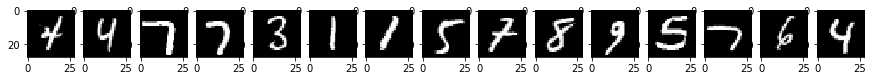

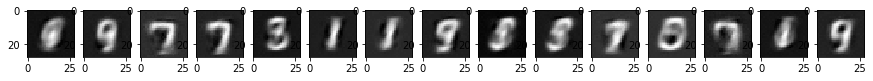

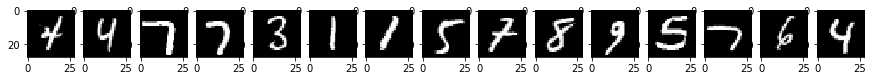

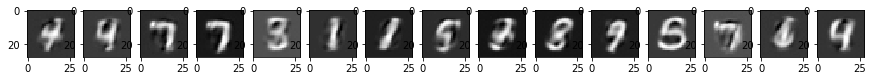

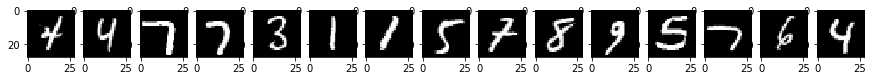

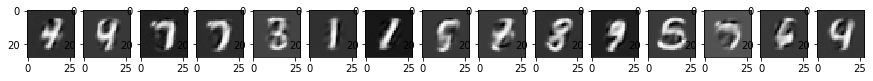

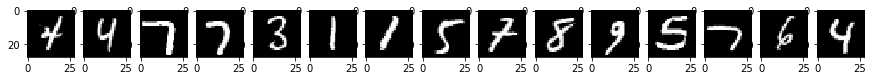

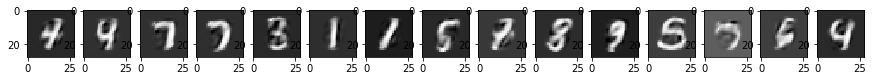

In [6]:
# Reconstructed images. 
def plot_imgs(imgs, size=1):
    ig, ax = plt.subplots(ncols=len(imgs), figsize=(len(imgs) * size, size))
    no_ticks = dict(left='off', bottom='off', labelleft='off', labelbottom='off')
    for index, img in enumerate(imgs):
        ax[index].imshow(img, cmap='gray')
        ax[index].tick_params(axis='both', which='both', **no_ticks)
    plt.show()
    

indices = np.random.choice(X_test.shape[0], 15, replace=False)

real = X_test[indices]

reco1 = recon1[indices]
plot_imgs(real)
plot_imgs(reco1)

reco5 = recon5[indices]
plot_imgs(real)
plot_imgs(reco5)

reco25 = recon25[indices]
plot_imgs(real)
plot_imgs(reco25)

reco50 = recon50[indices]
plot_imgs(real)
plot_imgs(reco50)

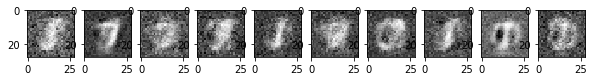

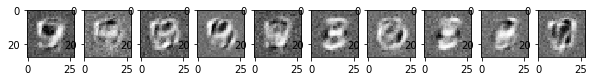

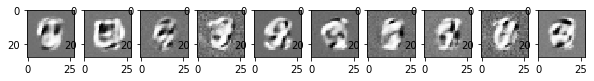

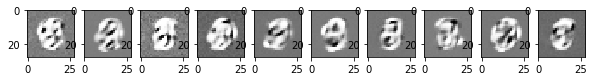

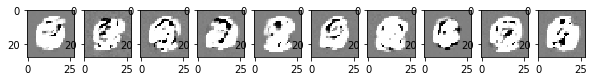

In [9]:
# Generated digits.
plot_imgs(gener1)
plot_imgs(gener5)
plot_imgs(gener25)
plot_imgs(gener50)
plot_imgs(test_samples)

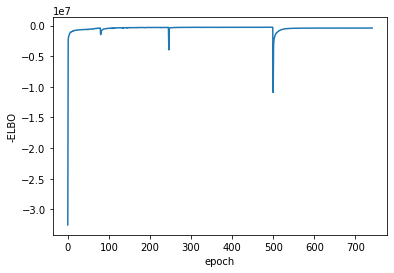

In [8]:
# Loss curve
sub = plt.subplot()
sub.plot(range(len(elbos)), elbos)
sub.set_xlabel('epoch')
sub.set_ylabel('-ELBO')
plt.show()